Detailed explanation:
https://medium.com/@alexppppp/how-to-train-a-custom-keypoint-detection-model-with-pytorch-d9af90e111da

GitHub repo:
https://github.com/alexppppp/keypoint_rcnn_training_pytorch

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 1. Imports

In [3]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F

import albumentations as A # Library for augmentations

/usr/local/lib/python3.7/dist-packages/pycocotools/cocoeval.py 

에서 밑과 같이 kpt_oks_sigmas 교체

self.kpt_oks_sigmas = np.array([.5, .5, .5, .5, .5, .5, .5, .5, .5, .5, .5])/10.0

In [4]:
import requests
urls = ['https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py',
        'https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py',
        'https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py',
        'https://raw.githubusercontent.com/pytorch/vision/main/references/detection/group_by_aspect_ratio.py',
        'https://raw.githubusercontent.com/pytorch/vision/main/references/detection/presets.py',
        'https://raw.githubusercontent.com/pytorch/vision/main/references/detection/train.py',
        'https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py',
        'https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py']

        
script_names = ['coco_eval.py',
                'coco_utils.py',
                'engine.py',
                'group_by_aspect_ratio.py',
                'presets.py',
                'train.py',
                'transforms.py',
                'utils.py']

 
for i in range(len(script_names)):
  resp = requests.get(urls[i])
  with open(script_names[i], 'w') as fp:
    fp.write(resp.text)


In [5]:
# https://github.com/pytorch/vision/tree/main/references/detection
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

# 2. Augmentations

# 3. Dataset class

In [6]:
class ClassDataset(Dataset):
    def __init__(self, root, transform=None, demo=False):                
        self.root = root
        self.transform = transform
        self.demo = demo # Use demo=True if you need transformed and original images (for example, for visualization purposes)
        self.imgs_files = sorted(os.listdir(os.path.join(root, "images")))[1:]
        self.annotations_files = sorted(os.listdir(os.path.join(root, "annotations")))[1:]
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs_files[idx])
        annotations_path = os.path.join(self.root, "annotations", self.annotations_files[idx])

        img_original = cv2.imread(img_path)
        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)        
        
        with open(annotations_path) as f:
            data = json.load(f)
            bboxes_original = [data['bboxes']]
            # print(bboxes_original)
            keypoints_original = data['keypoints']
            keypoints_original = [[[i[0], i[1], i[-1]] for i in keypoints_original]]
            # print(f"keypoints_original, {keypoints_original}") 
            
            # All objects are glue tubes
            bboxes_labels_original = ['Glue tube' for _ in bboxes_original]       
            # print(f"bboxes_labels_original, {bboxes_labels_original}")           

        if self.transform:   
          pass
        
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        target["boxes"] = bboxes
        target["labels"] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64) # all objects are glue tubes
        target["image_id"] = torch.tensor([idx])
        target["area"] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target["iscrowd"] = torch.zeros(len(bboxes), dtype=torch.int64)
        target["keypoints"] = torch.as_tensor(keypoints, dtype=torch.float32)        
        img = F.to_tensor(img)
        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original["boxes"] = bboxes_original
        target_original["labels"] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64) # all objects are glue tubes
        target_original["image_id"] = torch.tensor([idx])
        target_original["area"] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original["iscrowd"] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original["keypoints"] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original

        else:
            return img, target
    
    def __len__(self):
        return len(self.imgs_files)

# 4. Visualizing a random item from dataset

In [7]:
KEYPOINTS_FOLDER_TRAIN = '/content/drive/Shareddrives/SW2_0916/YKH/train'
dataset = ClassDataset(KEYPOINTS_FOLDER_TRAIN, transform=False, demo=True)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)

for i in range(len(dataset.annotations_files)):
  batch = next(iterator)
  print("Original targets:\n", batch[3], "\n\n")

Original targets:
 ({'boxes': tensor([[238.,  12., 558., 302.]]), 'labels': tensor([1]), 'image_id': tensor([16]), 'area': tensor([92800.]), 'iscrowd': tensor([0]), 'keypoints': tensor([[[348.,  84.,   1.],
         [376., 214.,   1.],
         [384.,  77.,   1.],
         [342.,  41.,   1.],
         [404., 129.,   1.],
         [420., 213.,   1.],
         [459., 205.,   1.],
         [475., 191.,   1.],
         [496., 173.,   1.],
         [516., 152.,   1.],
         [530., 132.,   1.]]])},) 


Original targets:
 ({'boxes': tensor([[241.,  64., 521., 254.]]), 'labels': tensor([1]), 'image_id': tensor([51]), 'area': tensor([53200.]), 'iscrowd': tensor([0]), 'keypoints': tensor([[[317., 171.,   1.],
         [372., 201.,   1.],
         [312.,  94.,   1.],
         [250., 128.,   1.],
         [380., 108.,   1.],
         [415., 166.,   1.],
         [425., 183.,   1.],
         [444., 196.,   1.],
         [464., 211.,   1.],
         [493., 221.,   1.],
         [503., 239.,   1.]

In [8]:
keypoints_classes_ids2names = {0:'tail_0', 
                               1:'tail_1', 
                               2:'tail_2', 
                               3:'tail_3', 
                               4:'tail_4', 
                               5:'tail_5', 
                               6:'spine', 
                               7:'neck', 
                               8:'nose', 
                               9:'fu', 
                               10:'hu'}


def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 5, (255,0,0), 10)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 10)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)
 

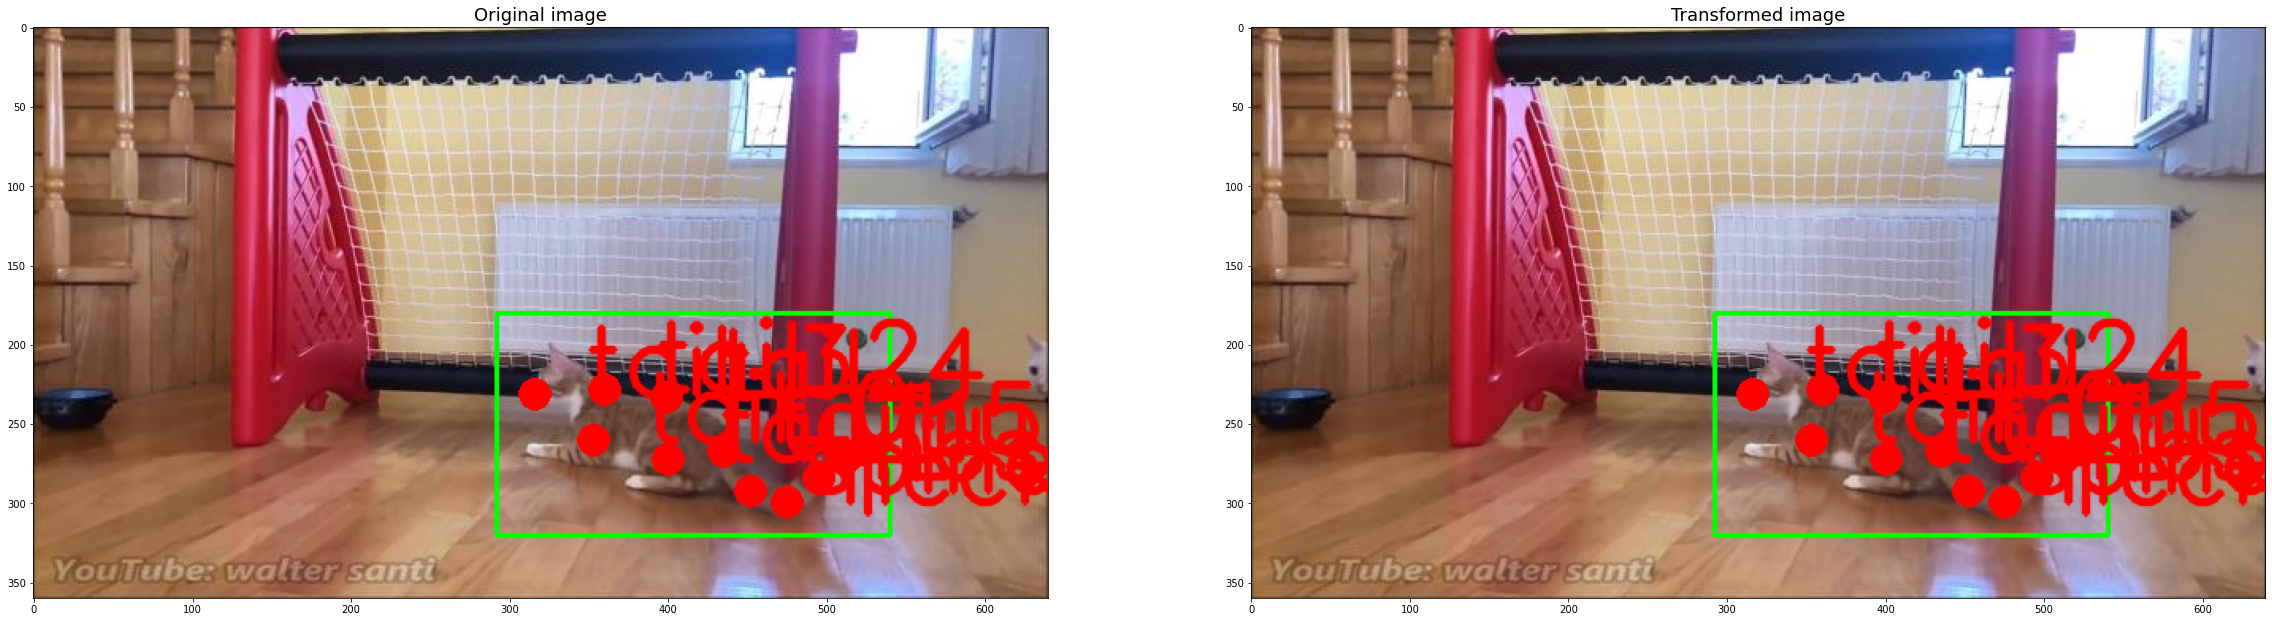

In [9]:
       
image = (batch[0][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1,2,0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

# 5. Training

In [10]:
def get_model(num_keypoints, weights_path=None):
    
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

KEYPOINTS_FOLDER_TRAIN = '/content/drive/Shareddrives/SW2_0916/YKH/train'
KEYPOINTS_FOLDER_TEST = '/content/drive/Shareddrives/SW2_0916/YKH/test'

dataset_train = ClassDataset(KEYPOINTS_FOLDER_TRAIN, False, demo=False)
dataset_test = ClassDataset(KEYPOINTS_FOLDER_TEST, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=5, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

model = get_model(num_keypoints=11)
model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and will be removed in 0.15, please use 'weights_backbone' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, 

In [12]:

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
num_epochs = 5

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1000)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)
    
# Save model weights after training
torch.save(model.state_dict(), 'keypointsrcnn_weights.pth')

Epoch: [0]  [ 0/13]  eta: 0:00:38  lr: 0.000084  loss: 9.3889 (9.3889)  loss_classifier: 0.6140 (0.6140)  loss_box_reg: 0.0196 (0.0196)  loss_keypoint: 8.0562 (8.0562)  loss_objectness: 0.6935 (0.6935)  loss_rpn_box_reg: 0.0057 (0.0057)  time: 2.9245  data: 0.0469  max mem: 4592
Epoch: [0]  [12/13]  eta: 0:00:00  lr: 0.001000  loss: 9.2383 (9.1719)  loss_classifier: 0.4562 (0.4141)  loss_box_reg: 0.0077 (0.0090)  loss_keypoint: 8.0694 (8.0462)  loss_objectness: 0.6917 (0.6897)  loss_rpn_box_reg: 0.0058 (0.0129)  time: 0.5398  data: 0.0417  max mem: 5529
Epoch: [0] Total time: 0:00:07 (0.5400 s / it)
creating index...
index created!
Test:  [0/1]  eta: 0:00:00  model_time: 0.1273 (0.1273)  evaluator_time: 0.0107 (0.0107)  time: 0.1483  data: 0.0095  max mem: 5529
Test: Total time: 0:00:00 (0.1489 s / it)
Averaged stats: model_time: 0.1273 (0.1273)  evaluator_time: 0.0107 (0.0107)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU met

# 6. Visualizing model predictions

In [13]:
iterator = iter(data_loader_test)

In [14]:
images, targets = next(iterator)
images = list(image.to(device) for image in images)

with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(images)

print("Predictions: \n", output)

Predictions: 
 [{'boxes': tensor([[142.3140, 103.6773, 469.6863, 285.2202],
        [258.8815,  32.9317, 427.4986, 356.5246],
        [184.3199,   8.3185, 355.4835, 337.1583],
        [248.8016, 100.9357, 578.4697, 291.7068],
        [ 60.0684,  23.2207, 403.8032, 295.4537],
        [296.0527,   0.0000, 490.9940, 322.6421],
        [  3.4713,  74.6869, 235.0162, 262.4384],
        [317.8310,  51.3388, 620.6617, 358.8900],
        [332.9796, 122.1806, 500.4662, 250.2400],
        [200.7068, 156.2730, 543.3197, 323.7568],
        [285.0600, 152.3784, 507.1654, 277.6067],
        [345.3872,   0.0000, 635.5680, 159.3026],
        [224.9604, 105.5440, 443.9831, 239.6889],
        [136.6255,   4.1693, 431.0709, 152.2204],
        [270.0477, 207.3529, 606.9271, 354.6849],
        [252.7098,   0.0000, 564.5306, 211.6330],
        [ 14.1536,   0.0000, 388.2136, 122.1208],
        [312.0194, 164.0210, 434.5242, 312.9169],
        [107.2002, 112.4599, 299.2957, 349.7051],
        [281.8230, 125.6

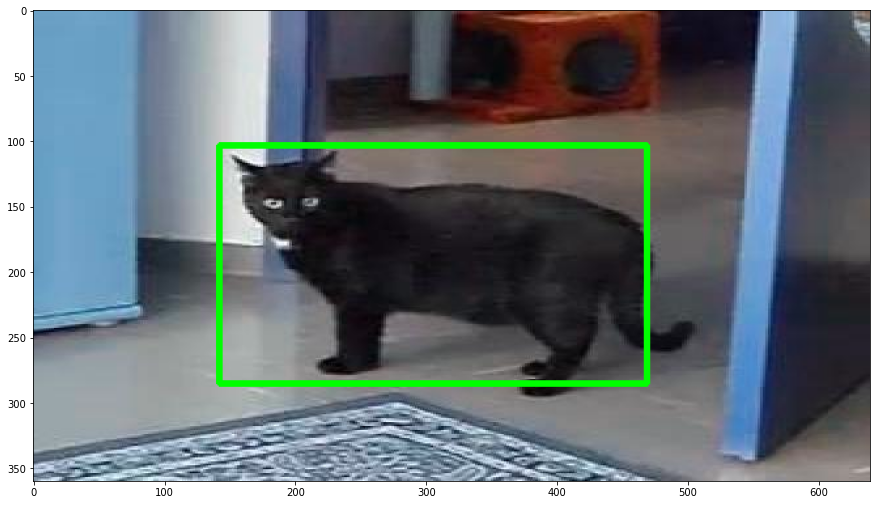

In [30]:
import math
from math import floor
bbox = [floor(142.3140), floor(103.6773), floor(469.6863), floor(285.2202)]

def visualize(image_path, bboxes, save=False):
    top_left_corner, bottom_right_corner = tuple([bboxes[0], bboxes[1]]), tuple([bboxes[2], bboxes[3]])
    image = cv2.imread(image_path)
    img = cv2.rectangle(image, top_left_corner, bottom_right_corner, (0, 255, 0), 3)
    
    # for kp_idx, kp in enumerate(keypoints):
    #    center = tuple([kp[0], kp[1]])
    #    img = cv.circle(img, center, 5, (255,0,0), 5)
    #    img = cv.putText(img, " " + label_dict[kp[2]], center, cv.FONT_HERSHEY_SIMPLEX, 1.0, (255,0,0), 2)
    
    # if save:
    #    try:
    #        cv.imwrite(f'./an_{image_path}.jpg', img)
    #    except:
    #        print("not saved")

    plt.figure(figsize=(15, 15))
    plt.imshow(img)

visualize("/content/drive/Shareddrives/SW2_0916/YKH/test/images/40_1_15_------------------------------------5290_png_jpg.rf.ebb4b0f52803ab733d5964ada6fb3f40.jpg",
          bbox)